In [1]:
import numpy as np
from trained_results_funcs import find_best_layer
from plotting_functions import plot_across_subjects
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
dataset_arr = ['pereira', 'fedorenko']
feature_extraction_arr = ['', '-mp', '-sp']
perf_arr = ['pearson_r', 'out_of_sample_r2']

In [3]:
resultsPath_base = '/data/LLMs/brainscore/'
figurePath = 'figures/new_figures/figure5/'

In [4]:
exp = ['243', '384']

br_labels_dict = {}
num_vox_dict = {}
subjects_dict = {}

data_processed_folder_pereira = f'/data/LLMs/data_processed/pereira/dataset'
data_processed_folder_fed = f'/data/LLMs/data_processed/fedorenko/dataset'
data_processed_folder_blank = f'/data/LLMs/data_processed/blank/dataset'

for e in exp:

    bre = np.load(f'{data_processed_folder_pereira}/networks_{e}.npy', allow_pickle=True)
    br_labels_dict[e] = bre
    num_vox_dict[e] = bre.shape[0]
    subjects_dict[e] = np.load(f"{data_processed_folder_pereira}/subjects_{e}.npy", allow_pickle=True)
    
lang_indices_384 = np.argwhere(br_labels_dict['384'] == 'language').squeeze()
lang_indices_243 = np.argwhere(br_labels_dict['243'] == 'language').squeeze()
lang_indices_dict = {}
lang_indices_dict['384'] = lang_indices_384
lang_indices_dict['243'] = lang_indices_243

subjects_arr_fed  = np.load(f"{data_processed_folder_fed}/subjects.npy", allow_pickle=True)
subjects_arr_blank  = np.load(f"{data_processed_folder_blank}/subjects.npy", allow_pickle=True)

subjects_arr_pereira = np.load(f"{data_processed_folder_pereira}/subjects_complete.npy", allow_pickle=True)
networks_arr_pereira = np.load(f"{data_processed_folder_pereira}/network_complete.npy", allow_pickle=True)
                    

Taking median value across voxels with a participant


/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Taking median value across voxels with a participant


/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


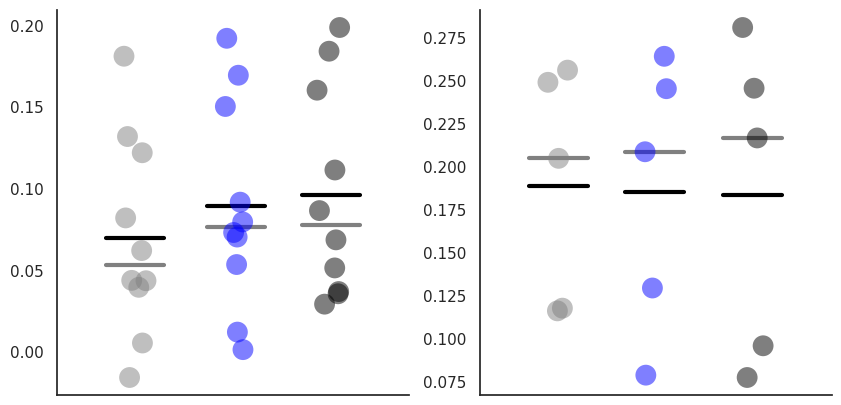

Clipping 0 values


/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Clipping 0 values


/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


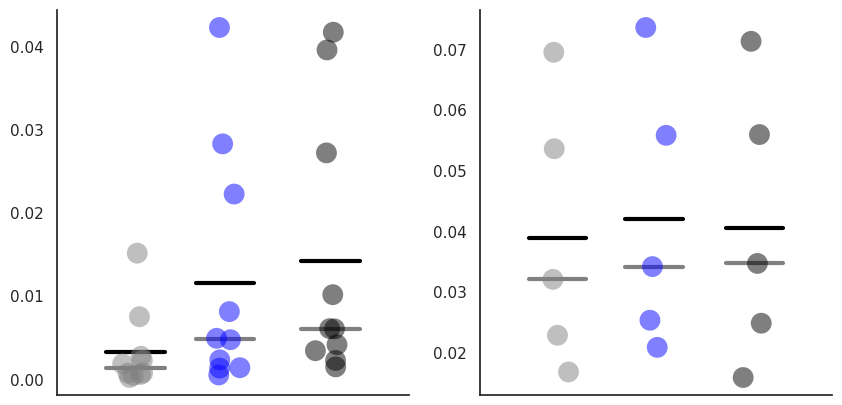

In [16]:
plot_legend = False
palette = ['gray', 'blue', 'black']
perf_str=''
plot_xlabel=False
remove_y_axis = False
num_seeds = 5

save_best_layer = []

for perf in perf_arr:
        
    if perf == 'pearson_r':
        clip_zero = False
        median = True
    else:
        clip_zero = True
        median = False
        
    fig, ax = plt.subplots(1, len(dataset_arr), figsize=(10,5))
            
    for dnum, d in enumerate(dataset_arr):
    
        results_dict_gpt2 = {'perf':[], 'subjects': [], 'Network': [], 
                                    'Model': []}
        if d == 'pereira':
            exp_arr = ['384', '243']
            
        else:
            
            exp_arr = ['']
        
            if d == 'fedorenko':
                subjects_arr = subjects_arr_fed
            if d == 'blank':
                subjects_arr = subjects_arr_blank
                    
            networks_arr = np.repeat('language', len(subjects_arr))
                            
        for fe in feature_extraction_arr:
            
            for i in range(num_seeds):
            
                for exp in exp_arr:
                    
                    if len(exp) > 0:
                        selected_lang_indices = lang_indices_dict[exp]
                        subjects_arr = subjects_dict[exp]
                        networks_arr = br_labels_dict[exp]
                        exp = f"_{exp}"
                    
                    else:
                        selected_lang_indices = None
                    
                    gpt2_xl_dict, gpt2_xl_bl, gpt2_xl_bl_perf  = find_best_layer(np.arange(49), noL2_str='', exp=exp, 
                                                                resultsPath=f"{resultsPath_base}results_{d}/untrained", 
                                                                perf=perf, feature_extraction=fe, selected_network_indices=selected_lang_indices, 
                                                                subjects=subjects_arr, dataset=d, model_name='gpt2-xl-untrained', seed_number=i)
                    
                    best_layer = max(gpt2_xl_dict[1], key=gpt2_xl_dict[1].get)
                    save_best_layer.append(f"{d}_gpt2-xl-untrained{fe}_layer_{best_layer}_1{exp}_m{i}.npz") 
            
                    results_dict_gpt2['perf'].extend(gpt2_xl_bl_perf)
                    results_dict_gpt2['subjects'].extend(subjects_arr)
                    results_dict_gpt2['Network'].extend(networks_arr)
                    results_dict_gpt2['Model'].extend(np.repeat(f'GPT2XLU{fe}', len(gpt2_xl_bl_perf)))
                
        results_dict_gpt2 = pd.DataFrame(results_dict_gpt2)
        
        subject_avg_pd, dict_pd_merged, dict_pd_with_all = plot_across_subjects(results_dict_gpt2.copy(), figurePath=figurePath,  selected_networks=['language'],
                                                            dataset=d, saveName=f'{d}_{fe}', order=['language'], clip_zero=clip_zero, color_palette=palette, 
                                                            draw_lines=False, ms=15, plot_legend=plot_legend, 
                                                            plot_legend_under=False, width=0.7, median=median, ylabel_str=perf_str, legend_fontsize=30, ax_select=ax[dnum],
                                                            remove_yaxis=remove_y_axis, plot_xlabel=plot_xlabel, alpha=0.5)
    plt.show()

In [21]:
import os
clean_y_hat = False
if clean_y_hat:
    d = 'fedorenko'
    for file in os.listdir(f"{resultsPath_base}results_{d}/untrained"):
        if file in save_best_layer:
            
            continue
        
        else:
            
            file_path = os.path.join(f"{resultsPath_base}results_{d}/untrained/", file)
            
            if 'gpt2-xl' in file_path:
                
                # Load the .npz file
                data = np.load(file_path, allow_pickle=True)
                data_dict = {key: data[key] for key in data.files if key != 'y_hat'}
                
                # Resave the modified data
                np.savez(file_path, **data_dict)
                print(f"Processed and resaved {file} without the 'y_hat' key")